# Capstone Project : Automobile Price Prediction

### The Problem
Our target business is a French car manufacturer **Peugeot Automobiles**.  Peugeot aims to enter the Indian Market by setting up a manufacturing unit in India and are planning to launch a new car model in the near future in competition with their European and American counterparts.<br>
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the Indian market, since those may be very different from the French market.<br>
The Company wants to figure out:<br>
 - Which variables significantly affect the price of a vehicle in the Indian Market
 - How well do these variables explain the price 


### About the dataset (Indian Cars dataset)
The dataset 'cars_ds_final.csv' is obtained from kaggle uploaded by Abhinav Medharkar (https://www.kaggle.com/medhekarabhinav5/indian-cars-dataset) .<br>
The dataset contains information about cars available for sale in the Indian Market and is updated 4th June 2020. It contains over 1200+ models and 140 features of these cars to study.<br><br>
Due to the sparsity of the dataset, 24 features are preselected based on the kind of questions one could expect a prospective buyer to answer so that a reasonable prediction vector can be established. The choice of features were also based on the amount of information available for the features and a common sense understanding of correlation between the variables. Variables that had very little data (<50% of the dataframe size) or would not matter to a prospective buyer were removed. There would still be quite a lot of data cleaning and features selection involved.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cars_ds_final.csv', index_col=0)

In [3]:
df.rename(columns={'Ex-Showroom_Price': 'Price'}, inplace=True)

In [4]:
# The following feature list was preselected after taking an in-depth look at each available feature (total 140)
# and amount of data in each feature and common sense co-relations
feature_list = ['Make', 'Model', 'Variant', 'Price', 'Displacement', 'Drivetrain', 
                'Emission_Norm', 'Engine_Location', 'Fuel_Type', 'Body_Type',
                'ARAI_Certified_Mileage', 'Kerb_Weight', 'Ground_Clearance', 'Power', 'Torque', 'Seating_Capacity', 
                'Seats_Material', 'Type', 'Wheelbase', 'Boot_Space','Child_Safety_Locks', 'Number_of_Airbags', 
                'Infotainment_Screen']


In [5]:
# Drop the remaining features
features_drop = list(set(df.columns) - set(feature_list))
cars_df = df.drop(features_drop, axis=1)
cars_df.rename(columns={'Type': 'Transmission_Type'}, inplace=True)
cars_df.head()

,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Engine_Location,Fuel_Type,Body_Type,...,Power,Torque,Seating_Capacity,Seats_Material,Transmission_Type,Wheelbase,Boot_Space,Child_Safety_Locks,Number_of_Airbags,Infotainment_Screen
0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,RWD (Rear Wheel Drive),BS IV,"Rear, Transverse",Petrol,Hatchback,...,38PS@5500rpm,51Nm@4000rpm,4.0,Fabric,Manual,2230 mm,110 litres,Yes,NaN,NaN
1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,RWD (Rear Wheel Drive),BS IV,"Rear, Transverse",Petrol,Hatchback,...,38PS@5500rpm,51Nm@4000rpm,4.0,Fabric,Manual,2230 mm,110 litres,Yes,NaN,NaN
2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,RWD (Rear Wheel Drive),BS IV,"Rear, Transverse",CNG,Hatchback,...,38PS@5500rpm,51Nm@4000rpm,4.0,Fabric,Manual,2230 mm,110 litres,Yes,NaN,NaN
3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624 cc,RWD (Rear Wheel Drive),BS IV,"Rear, Transverse",Petrol,Hatchback,...,38PS@5500rpm,51Nm@4000rpm,4.0,Fabric,Automatic,2230 mm,94 litres,Yes,NaN,NaN
4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624 cc,RWD (Rear Wheel Drive),BS IV,"Rear, Transverse",Petrol,Hatchback,...,38PS@5500rpm,51Nm@4000rpm,4.0,Fabric,Manual,2230 mm,110 litres,Yes,NaN,NaN


In [6]:
# Initial look on what the data has to offer
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1275
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Make                    1201 non-null   object 
 1   Model                   1276 non-null   object 
 2   Variant                 1276 non-null   object 
 3   Price                   1276 non-null   object 
 4   Displacement            1264 non-null   object 
 5   Drivetrain              1269 non-null   object 
 6   Emission_Norm           1265 non-null   object 
 7   Engine_Location         1233 non-null   object 
 8   Fuel_Type               1276 non-null   object 
 9   Body_Type               1270 non-null   object 
 10  ARAI_Certified_Mileage  1162 non-null   object 
 11  Kerb_Weight             911 non-null    object 
 12  Ground_Clearance        987 non-null    object 
 13  Power                   1276 non-null   object 
 14  Torque                  1274 non-null   

In [7]:
cars_df.describe()

,Seating_Capacity,Number_of_Airbags
count,1270.000000,1141.000000
mean,5.270079,3.787029
std,1.145231,2.522399
min,2.000000,1.000000
25%,5.000000,2.000000
50%,5.000000,2.000000
75%,5.000000,6.000000
max,16.000000,14.000000


## 1. Data wrangling

As we can see, there is a lot of missing data to deal with, string manipulation will be required and object dtypes need to made consistent with the type of features set.<br>
Lets first split the dataframe into target variables, numerical variables and categorical variables. We do this because these three categories require seperate wrangling approaches.

In [8]:
target_vars = ['Make', 'Model', 'Variant']
num_vars = ['Price', 'Displacement', 'ARAI_Certified_Mileage', 'Kerb_Weight',
            'Ground_Clearance', 'Power', 'Torque', 'Seating_Capacity', 'Wheelbase', 'Boot_Space', 'Number_of_Airbags']
cat_vars = ['Drivetrain', 'Emission_Norm', 'Engine_Location', 'Fuel_Type', 'Body_Type', 
            'Seats_Material', 'Transmission_Type', 'Child_Safety_Locks', 'Infotainment_Screen']

### 1.1 Cleaning up the target variables

In [9]:
# Missing entries in car 'Make'
cars_df[cars_df['Make'].isna()]['Model'].unique()

array(['Mercedes-Benz B-Class', 'Mercedes-Benz Cla-Class',
       'Mercedes-Benz E-Class Cabriolet', 'Mercedes-Benz Gls',
       'Mercedes-Benz S-Class', 'Mercedes-Benz G-Class',
       'Mercedes-Benz Maybach', 'Mercedes-Benz S-Class Cabriolet',
       'Rolls-Royce Ghost Series Ii', 'Rolls-Royce Wraith',
       'Rolls-Royce Cullinan', 'Rolls-Royce Phantom Coupe',
       'Mercedes-Benz E-Class', 'Mercedes-Benz C-Class Cabriolet',
       'Mercedes-Benz V-Class', 'Mercedes-Benz E-Class All Terrain',
       'Mercedes-Benz Amg-Gt', 'Mercedes-Benz Amg Gt 4-Door Coupe',
       'Rolls-Royce Dawn', 'Rolls-Royce Drophead Coupe', 'Go+',
       'Mercedes-Benz A-Class', 'Mercedes-Benz C-Class',
       'Mercedes-Benz Gle', 'Mercedes-Benz Cls',
       'Mercedes-Benz Gla-Class', 'Rolls-Royce Phantom',
       'Mercedes-Benz Glc'], dtype=object)

In [10]:
# Add missing 'Make' values in Mercedes-Benz, Rolls-Royce and Datsun Models and clean up the Model entries
# Also clean up some Datsun and Land rover variants
merc_cleanup_bool = cars_df['Model'].str.contains('Mercedes-Benz')
cars_df.loc[merc_cleanup_bool, 'Make'] = 'Mercedes-Benz'
cars_df.loc[merc_cleanup_bool, 'Model'] = cars_df.loc[merc_cleanup_bool, 'Model'].str.split(n=1, expand=True)[1]

RR_cleanup_bool = cars_df['Model'].str.contains('Rolls-Royce')
cars_df.loc[RR_cleanup_bool, 'Make'] = 'Rolls-Royce'
cars_df.loc[RR_cleanup_bool, 'Model'] = cars_df.loc[RR_cleanup_bool, 'Model'].str.split(n=1, expand=True)[1]

cars_df.loc[cars_df.Model == 'Go+', 'Make'] = 'Datsun'
datsun_cleanup_bool = cars_df['Variant'].str.contains('Datsun')
cars_df.loc[datsun_cleanup_bool, 'Variant'] = cars_df.loc[datsun_cleanup_bool, 'Variant'].str.split(n=1, expand=True)[1]

cars_df.loc[cars_df['Make']=='Maruti Suzuki R', 'Model'] = 'Wagon R'
cars_df.loc[cars_df['Make']=='Maruti Suzuki R', 'Make'] = 'Maruti Suzuki'

cars_df.loc[cars_df['Make'].str.contains('Land Rover'), 'Make'] = 'Land Rover'

### 1.2 Exploring the numerical features for regularity of expression and incorrect values

In [11]:
# Exploring the numerical features for regularity of expression and incorrect values

def feat_exp_chk(df, feat_list, exp_list):
    
    # The function checks a list of columns in a dataframe against a list of regex,
    # prints out the summary and creates a dataframe of problematic entries that dont match
    
    issues_df = pd.DataFrame()
    print('Feature', '|', 'Non Null Values', '|', 'String consistent entries')
    
    for (feat, exp) in zip(feat_list, exp_list):
        # Expression to be matched against column entries
        exp_match = df[feat].str.match(exp, case=False)
        # Print match summary
        print(feat, '|', df[feat].count(), '|', exp_match.sum())
        # Create a dataframe of with information on the unmatched entries
        issues_df = issues_df.append(pd.DataFrame({'feature': feat,'entry':df.loc[exp_match == False, feat]}))
    return issues_df

In [12]:
# Check the numerical variables against string expression patterns
# We'll leave Seating_Capacity, Number_of_Airbags as they are already in float format and look good upon inspection
num_vars_chklist = [feat for feat in num_vars if feat not in ('Seating_Capacity', 'Number_of_Airbags')]

exp_chk_num = ['^Rs. \d*,\d*,\d*', '^\d{2,4} cc', '^\d+(\.\d*)? km/litre', '^\d+(\.\d*)? kg', 
                '^\d+(\.\d*)? mm', '^\d+(\.\d*)?\s?(PS|hp|bhp)', '^\d+(\.\d*)?\s?(nm)','^\d+(\.\d*)?\s?mm',
               '^\d+(\.\d*)? litres']

issues_1 = feat_exp_chk(cars_df, num_vars_chklist, exp_chk_num)

print('Numerical variables with pattern issues:', issues_1.feature.unique())

Feature | Non Null Values | String consistent entries
Price | 1276 | 1276
Displacement | 1264 | 1264
ARAI_Certified_Mileage | 1162 | 1159
Kerb_Weight | 911 | 899
Ground_Clearance | 987 | 987
Power | 1276 | 1272
Torque | 1274 | 1266
Wheelbase | 1256 | 1256
Boot_Space | 1027 | 1018
Numerical variables with pattern issues: ['ARAI_Certified_Mileage' 'Kerb_Weight' 'Power' 'Torque' 'Boot_Space']


In [13]:
# We replace the string inconsistent entries by nan and tackle them later by avergaing methods of fillna.
for feat in issues_1.feature.unique():
    cars_df.loc[issues_1[issues_1['feature']==feat].index, feat] = np.nan


Now that all the numerical variables are consistent in their representation as strings, we extract these numerical values and convert them into numeric format.

In [14]:
cars_df['Price'] = cars_df['Price'].str.replace('Rs. ', "")
cars_df['Price'] = cars_df['Price'].str.replace(',', "")

for feat in [feat for feat in num_vars_chklist if feat not in 'Price']:
    cars_df[feat] = cars_df[feat].str.extract(r'(^\d+\.?\d*)')

cars_df[num_vars_chklist] = cars_df[num_vars_chklist].apply(pd.to_numeric)
cars_df[num_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1275
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1276 non-null   int64  
 1   Displacement            1264 non-null   float64
 2   ARAI_Certified_Mileage  1159 non-null   float64
 3   Kerb_Weight             899 non-null    float64
 4   Ground_Clearance        987 non-null    float64
 5   Power                   1272 non-null   float64
 6   Torque                  1266 non-null   float64
 7   Seating_Capacity        1270 non-null   float64
 8   Wheelbase               1256 non-null   float64
 9   Boot_Space              1018 non-null   float64
 10  Number_of_Airbags       1141 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 159.6 KB


Now we try to fill in the missing values with average values by model.<br>
We replace the nan values in Child_Safety_Lock and Number_of_Airbags by 0 (meaning those without data are assumed to not have the feature present)

In [15]:
# We reduce some of the null values by filling the N/A's with the mean values by 'Model'
for feat in num_vars_chklist:
    cars_df[feat] = cars_df.groupby('Model')[feat].transform(lambda x: x.fillna(x.mean()))

cars_df['Number_of_Airbags'] = cars_df['Number_of_Airbags'].fillna(0)

In [16]:
# Few null values are reduced but looks like a few features are missing for entire models.
cars_df[num_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1275
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1276 non-null   int64  
 1   Displacement            1264 non-null   float64
 2   ARAI_Certified_Mileage  1229 non-null   float64
 3   Kerb_Weight             977 non-null    float64
 4   Ground_Clearance        1037 non-null   float64
 5   Power                   1274 non-null   float64
 6   Torque                  1274 non-null   float64
 7   Seating_Capacity        1270 non-null   float64
 8   Wheelbase               1268 non-null   float64
 9   Boot_Space              1076 non-null   float64
 10  Number_of_Airbags       1276 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 159.6 KB


Next we investigate the left over null values.<br>
These are values where all the model variants have N/A's for a particular feature in their models.<br>
 -  We tackle Kerb_Weight, Ground_Clearance, Seating_Capacity, Wheelbase and Boot_Space by averaging out by body type. These are in a way features of the body type.<br>
 -  To deal with ARAI_Certified_Mileage, we fill in the missing values using a groupby median of Body_Type and Fuel_Type and convert it into a more rubust feature for comparison- 'Cost_per_Km'. For the electric vehicles, we have to enter values manually.<br>
 -  Lastly we will fill in the missing Displacement values by interpolating through 'Power' as this will be the best method to estimate the engine displacement of the missing values.<br>

In [17]:
cars_df.Body_Type.unique()

array(['Hatchback', 'MPV', 'MUV', 'SUV', 'Sedan', 'Crossover', nan,
       'Coupe', 'Convertible', 'Sports, Hatchback', 'Sedan, Coupe',
       'Sports', 'Crossover, SUV', 'SUV, Crossover', 'Sedan, Crossover',
       'Sports, Convertible', 'Pick-up', 'Coupe, Convertible'],
      dtype=object)

In [ ]:
# In order to use Body_type and Fuel_type for data imputation, we first need to clean them up.

cars_df['Body_Type'].replace(to_replace = ['MPV', 'Crossover', 'Coupe', 'Convertible', 'Sports, Hatchback',
                                           'Sedan, Coupe','Crossover, SUV', 'SUV, Crossover', 'Sedan, Crossover',
                                           'Sports, Convertible', 'Pick-up', 'Coupe, Convertible', 'Sports'],
                             value = ['MUV','MUV', 'Luxury', 'Luxury', 'Hatchback', 'Luxury', 'SUV', 'SUV', 'Sedan',
                                     'Luxury', 'SUV', 'Luxury', 'Luxury'], inplace=True)

cars_df['Fuel_Type'].replace(['CNG + Petrol', 'Hybrid'], 'Petrol', inplace=True)

In [21]:
# Manually filling the missing/erronous entries
# These have been identified by looking as the missing values as well as investigating the outliers

cars_df.loc[239, 'Body_Type'] = 'SUV'
cars_df.loc[843:845, 'Body_Type'] = 'Sedan'
cars_df.loc[1253:1254, 'Body_Type'] = 'Luxury'

cars_df.loc[353, 'Power'] = 563.
cars_df.loc[1204, 'Power'] = 90.

cars_df.loc[807:808, 'Torque'] = 500.
cars_df.loc[495, 'Torque'] = 171.2
cars_df.loc[1175, 'Torque'] = 113

cars_df.loc[802:804, 'Ground_Clearance'] = 204.

cars_df.loc[cars_df['Model']=='X4', 'Boot_Space'] = 525.
cars_df.loc[cars_df['Model'].str.contains('Bolero'), 'Boot_Space'] = 550.
cars_df.loc[cars_df['Model']=='Range Sport', 'Boot_Space'] = 623.

cars_df.loc[843:845, 'Number_of_Airbags'] = 7.
cars_df.loc[1166:1169, 'Number_of_Airbags'] = 6.
cars_df.loc[1046, 'Number_of_Airbags'] = 6.
cars_df.loc[cars_df['Make']=='Mini', 'Number_of_Airbags'] = 6.

# Fixing a few incorrect entries (Mercedes Benz)
cars_df.loc[cars_df['ARAI_Certified_Mileage'] > 50, 'ARAI_Certified_Mileage'] = 14.2
cars_df.loc[840, 'ARAI_Certified_Mileage'] = 31

In [22]:
# Fill NA's for the body related features by averaging out by Body_Type

for feat in ['Kerb_Weight', 'Ground_Clearance', 'Seating_Capacity', 'Wheelbase', 'Boot_Space']:
    cars_df[feat] = cars_df.groupby('Body_Type')[feat].transform(lambda x: x.fillna(x.median()))
    
cars_df[num_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1275
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1276 non-null   int64  
 1   Displacement            1264 non-null   float64
 2   ARAI_Certified_Mileage  1229 non-null   float64
 3   Kerb_Weight             1276 non-null   float64
 4   Ground_Clearance        1276 non-null   float64
 5   Power                   1276 non-null   float64
 6   Torque                  1276 non-null   float64
 7   Seating_Capacity        1276 non-null   float64
 8   Wheelbase               1276 non-null   float64
 9   Boot_Space              1276 non-null   float64
 10  Number_of_Airbags       1276 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 159.6 KB


Next we convert the ARAI_Certified_Mileage into Cost_per_Km which would act as a standardized feature that can be compared for all kinds of Fuel_Types (including Electric)

In [23]:
cars_df['ARAI_Certified_Mileage'] = cars_df.groupby(['Body_Type', 'Fuel_Type'])\
                                    ['ARAI_Certified_Mileage'].transform(lambda x: x.fillna(x.median()*0.85))

#We take a 15% decrement because all missing mileages are for high end models or electric (which are skipped for now)

Only electric vehicles are left without the ARAI_Certified_Mileage. To account for electric vehicles and have a common base of comparison of all fuel types, we convert this column to another feature 'Cost_per_Km' which factors in the different prices of the various fuels as well.

In [24]:
# Convert mileage in km/ltr to Cost_per_km for convinience in comparing differently fueled
# cars, including electric vehicles

cars_df['Cost_per_Km'] = ""

# Prices in delhi as on Apr 28, 2021

petrol_price = 90.4 #per ltr
diesel_price = 80.73 #per ltr
CNG_price = 43.4 #per kg

# Calculating the cost per Km
def Cost_per_Km():
    for i in cars_df.index.to_list():
        if pd.isnull(cars_df.loc[i, 'ARAI_Certified_Mileage']):
            cars_df.loc[i, 'Cost_per_Km'] = np.nan
        else:
            if cars_df.loc[i, 'Fuel_Type'] == 'Petrol':
                cars_df.loc[i, 'Cost_per_Km'] = petrol_price/cars_df.loc[i, 'ARAI_Certified_Mileage']
            elif cars_df.loc[i, 'Fuel_Type'] == 'Diesel':
                cars_df.loc[i, 'Cost_per_Km'] = diesel_price/cars_df.loc[i, 'ARAI_Certified_Mileage']
            elif cars_df.loc[i, 'Fuel_Type'] == 'CNG':
                cars_df.loc[i, 'Cost_per_Km'] = CNG_price/cars_df.loc[i, 'ARAI_Certified_Mileage']

Cost_per_Km()
cars_df['Cost_per_Km'] = cars_df['Cost_per_Km'].astype('float')

In [25]:
# Filling in the Cost_per_Km for electric vehicles
null_mileage_models = cars_df[cars_df['ARAI_Certified_Mileage'].isnull()].Model.unique().tolist()
null_mileage_models

['E2O Plus', 'Tigor Ev', 'E Verito', 'Zs Ev', 'Nexon Ev', 'Kona Electric']

In [26]:
cost_km_elec = [0.52, 0.92, 0.92, 0.80, 0.59, 0.53]

for model, cost in zip(null_mileage_models, cost_km_elec):
    cars_df.loc[cars_df['Model']==model, 'Cost_per_Km'] = cost
    
# We drop ARAI_Certified_Mileage in lieu of Cost_per_Km
cars_df.drop(columns='ARAI_Certified_Mileage', inplace=True)

# Update the numeric variables list
num_vars = ['Cost_per_Km' if feat=='ARAI_Certified_Mileage' else feat for feat in num_vars]

Next we deal with Displacement using an interpolation through Power

In [27]:
# Fill the displacement using interpolate method and fill on the nearest sorted by Power.

cars_df['Displacement'] = cars_df.sort_values('Power')['Displacement'].interpolate(method='nearest', \
                                                        limit_direction='backward').sort_index()

### 1.3 Cleaning up the Categorical variables

Lets look at the unique values present in different categorical variables

In [28]:
for feat in cat_vars:
    print(feat, '|',cars_df[feat].count(), '|',  cars_df[feat].unique())

Drivetrain | 1269 | ['RWD (Rear Wheel Drive)' 'FWD (Front Wheel Drive)'
 'AWD (All Wheel Drive)' '4WD' nan]
Emission_Norm | 1265 | ['BS IV' 'BS 6' nan 'BS III' 'BS VI']
Engine_Location | 1233 | ['Rear, Transverse' 'Front, Transverse' 'Front, Longitudinal' nan
 'Rear Mid, Transverse' 'Mid, Longitudinal' 'Mid, Transverse'
 'Rear, Longitudinal']
Fuel_Type | 1276 | ['Petrol' 'CNG' 'Diesel' 'Electric']
Body_Type | 1276 | ['Hatchback' 'MUV' 'SUV' 'Sedan' 'Luxury']
Seats_Material | 1264 | ['Fabric' 'Leather' 'Polyurethene' nan 'Vinyl']
Transmission_Type | 1275 | ['Manual' 'Automatic' 'AMT' 'CVT' 'DCT' nan]
Child_Safety_Locks | 1201 | ['Yes' nan]
Infotainment_Screen | 814 | [nan 'Touch Sensitive' 'Yes']


In [31]:
# Reducing the categories for practicalilty

cars_df['Drivetrain'].replace(to_replace = ['AWD (All Wheel Drive)', 'RWD (Rear Wheel Drive)', 
                                            'FWD (Front Wheel Drive)'], 
                              value = ['4WD', 'RWD', 'FWD'], inplace=True)
                                #Practically the same thing to the customer
cars_df['Emission_Norm'].replace(to_replace = ['BS IV', 'BS 6', 'BS III', 'BS VI'],
                                 value = ['BS_IV', 'BS_VI', 'BS_III', 'BS_VI'], inplace=True) 

cars_df['Engine_Location'].replace(to_replace = ['Rear, Transverse', 'Front, Transverse', 'Front, Longitudinal', 
                                                 'Rear Mid, Transverse', 'Mid, Longitudinal', 'Mid, Transverse', 
                                                 'Rear, Longitudinal'], 
                                   value =  ['Rear', 'Front', 'Front', 'Rear', 'Mid', 'Mid', 'Rear'], inplace=True)
                                    #Reduced to positions only, engine orientation left out
cars_df['Seats_Material'].replace(['Vinyl', 'Polyurethene'], 'Fabric', inplace=True) 
                                    #Very limited entiries in Vinyl and Polyurethene
cars_df['Transmission_Type'].replace(['AMT', 'CVT', 'DCT'], 'Automatic', inplace=True) 
                                    #Practically the same thing to the customer
cars_df['Infotainment_Screen'].replace('Touch Sensitive', 'Yes', inplace=True)

We will try to fill in the Null values for categorical variables in the following way:<br>
 - <b>Drivetrain, Emission_Norm, Engine_Location, Seats_Material, Transmission_Type : </b>By the most common value (mode) grouped by make. <br>
 - <b>Child_Safety_Locks, Infotainment_Screen :</b> NaN values will replaced by 'No'<br>

In [32]:
# Filling in the missing values for categorical variables

for feat in ['Drivetrain', 'Emission_Norm', 'Engine_Location', 'Seats_Material', 'Transmission_Type']:
    cars_df[feat] = cars_df.groupby('Make')[feat].transform(lambda x: x.fillna(x.mode()[0]))

cars_df['Child_Safety_Locks'] = cars_df['Child_Safety_Locks'].fillna('No')
cars_df['Infotainment_Screen'] = cars_df['Infotainment_Screen'].fillna('No')

In [33]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1275
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Make                 1276 non-null   object 
 1   Model                1276 non-null   object 
 2   Variant              1276 non-null   object 
 3   Price                1276 non-null   int64  
 4   Displacement         1276 non-null   float64
 5   Drivetrain           1276 non-null   object 
 6   Emission_Norm        1276 non-null   object 
 7   Engine_Location      1276 non-null   object 
 8   Fuel_Type            1276 non-null   object 
 9   Body_Type            1276 non-null   object 
 10  Kerb_Weight          1276 non-null   float64
 11  Ground_Clearance     1276 non-null   float64
 12  Power                1276 non-null   float64
 13  Torque               1276 non-null   float64
 14  Seating_Capacity     1276 non-null   float64
 15  Seats_Material       1276 non-null   o

### 1.4. Treating the Outliers

In [34]:
cars_df.describe()

,Price,Displacement,Kerb_Weight,Ground_Clearance,Power,Torque,Seating_Capacity,Wheelbase,Boot_Space,Number_of_Airbags,Cost_per_Km
count,1.276000e+03,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
mean,4.596538e+06,1858.221787,1398.757217,177.557994,156.446306,265.420790,5.263323,2629.248041,385.407412,3.435737,5.133457
std,1.214735e+07,1060.603296,459.309336,28.126329,135.633235,179.818135,1.154539,209.313380,143.845902,2.662997,2.141102
min,2.364470e+05,72.000000,660.000000,100.000000,12.000000,16.100000,2.000000,1840.000000,20.000000,0.000000,0.520000
25%,7.438760e+05,1198.000000,1030.000000,164.000000,83.000000,133.000000,5.000000,2470.000000,265.000000,2.000000,3.938049
50%,1.060064e+06,1497.000000,1228.000000,170.000000,110.000000,209.000000,5.000000,2600.000000,390.000000,2.000000,4.708333
75%,2.979828e+06,1998.000000,1725.000000,200.000000,173.000000,350.000000,5.000000,2740.000000,475.000000,6.000000,5.614907
max,2.121554e+08,7993.000000,2962.000000,307.000000,1479.000000,1600.000000,16.000000,3820.000000,1050.000000,14.000000,22.600000


Since our customer is a Mid segment car manufacturer, we can treat the high-end cars in the data base as outliers and limit our data for better prediction amongst the concerned class of cars.<br>
We limit our database to cars within the Rs. 2 Crore range.

In [35]:
cars_df = cars_df[cars_df['Price'] <= 2.0E7]

In [36]:
cars_df.describe()

,Price,Displacement,Kerb_Weight,Ground_Clearance,Power,Torque,Seating_Capacity,Wheelbase,Boot_Space,Number_of_Airbags,Cost_per_Km
count,1.207000e+03,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,2.438693e+06,1666.751450,1363.603452,178.556752,131.920867,238.731506,5.358741,2614.078293,385.696887,3.303231,4.849999
std,3.470370e+06,660.990438,432.442211,25.105199,80.049302,138.128086,1.043683,194.238331,137.095371,2.614702,1.559006
min,2.364470e+05,72.000000,660.000000,100.000000,12.000000,16.100000,2.000000,1840.000000,20.000000,0.000000,0.520000
25%,7.250000e+05,1198.000000,1018.500000,165.000000,83.000000,120.000000,5.000000,2469.000000,268.000000,2.000000,3.930435
50%,9.999000e+05,1497.000000,1225.000000,170.000000,105.000000,200.000000,5.000000,2590.000000,390.000000,2.000000,4.638276
75%,2.142000e+06,1994.000000,1725.000000,198.000000,155.000000,320.000000,5.000000,2700.000000,475.000000,6.000000,5.380952
max,1.989000e+07,6417.000000,2962.000000,307.000000,625.000000,770.000000,16.000000,3488.000000,1050.000000,14.000000,12.216216


Next we take a look at the univariate distributions of the numeric variables and remove the outliers from seemingly normal distributions using the zscore.

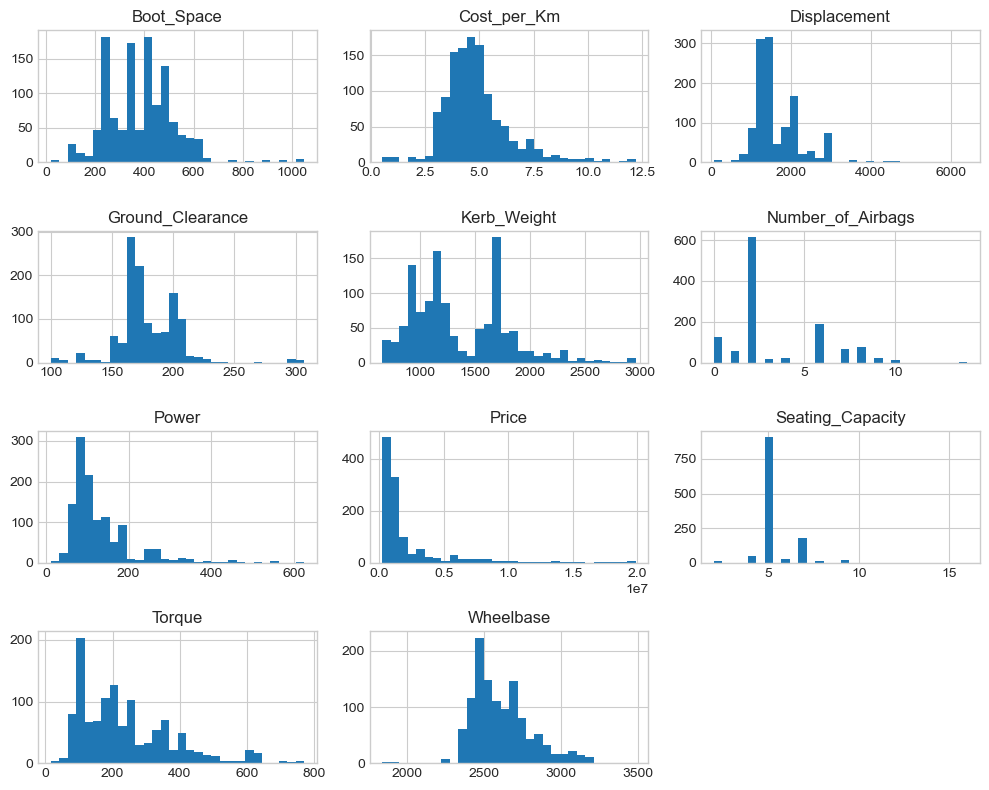

In [37]:
plt.rcdefaults()
plt.style.use('seaborn-whitegrid')
cars_df.hist(figsize=(10,8), bins=30)
plt.tight_layout()
plt.show()

In [38]:
from scipy import stats

In [39]:
from scipy import stats
# Since we have already limited Price, we will exclude it from the list
num_norm = [feat for feat in num_vars if feat not in ('Price', 'Number_of_Airbags', 'Seating_Capacity')]
cars_df = cars_df[(stats.zscore(cars_df[num_norm])<3).all(axis=1)]

# We manually drop the outliers from Number_of_Airbags
cars_df.drop(cars_df[cars_df['Number_of_Airbags']>10].index, inplace=True)

In [40]:
cars_df.describe()

,Price,Displacement,Kerb_Weight,Ground_Clearance,Power,Torque,Seating_Capacity,Wheelbase,Boot_Space,Number_of_Airbags,Cost_per_Km
count,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,1.784870e+06,1566.120000,1313.500000,177.476444,117.539988,218.700677,5.363556,2590.413333,374.205460,3.034667,4.641440
std,2.178190e+06,502.372188,382.943915,19.644667,54.034368,115.642577,0.953690,170.128140,118.992507,2.407663,1.256258
min,2.364470e+05,72.000000,660.000000,100.000000,12.000000,16.100000,2.000000,1840.000000,20.000000,0.000000,0.520000
25%,7.029460e+05,1198.000000,1001.000000,165.000000,83.000000,115.000000,5.000000,2460.000000,265.000000,2.000000,3.913420
50%,9.830000e+05,1493.000000,1184.000000,170.000000,100.000000,200.000000,5.000000,2555.000000,378.000000,2.000000,4.497512
75%,1.716319e+06,1968.000000,1725.000000,192.000000,141.000000,280.000000,5.000000,2688.000000,465.000000,6.000000,5.242208
max,1.650000e+07,3456.000000,2510.000000,241.000000,360.000000,620.000000,9.000000,3157.000000,759.000000,10.000000,9.397089


## 2. Exploratory Data Analysis (EDA)

Since our client is a mid segment manufacturer, we will pay closer attention to the price distribution of cars within the Rs. 50 Lakh price band during the EDA to get better insights into the market patterns and competitor psychology.<br>
The questions we will look to answer will be along the lines of:
1. How are the cars distributed relative to the 'Price' variable?
2. Can we say anything about our competitors' pricing strategy?
3. Can we observe any significant impact of the categorical predictor variables on price.
4. Can we spot any patterns of correlation between 'Price' and the numerical predictors chosen?

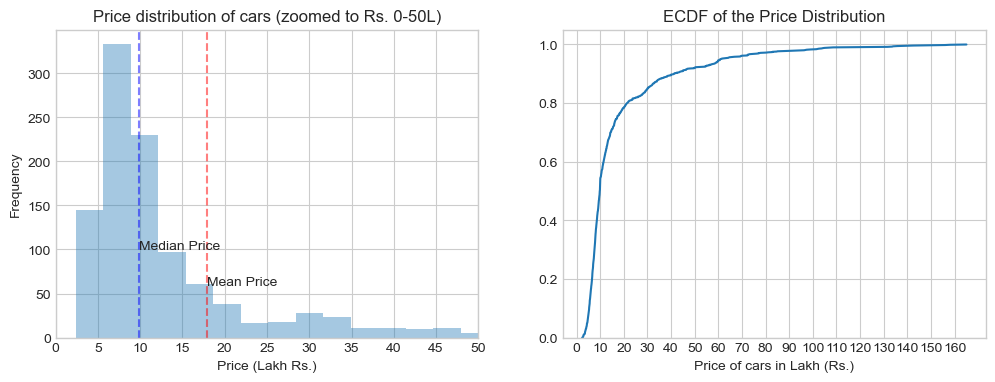

In [41]:
# Plotting the Price Distribution

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(12,4))
cars_df_50 = cars_df[cars_df['Price']< 5.0E6]
sns.distplot(cars_df['Price'], ax=ax[0], kde=0)
ax[0].axvline(cars_df['Price'].mean(), c='red', linestyle='--', alpha=0.5)
ax[0].axvline(cars_df['Price'].median(), c='blue', linestyle='--', alpha=0.5)
ax[0].set(xticks=np.arange(0, 6.0E6, 5.0E5), xticklabels=np.arange(0, 60, 5), xlabel='Price (Lakh Rs.)',
      ylabel='Frequency', title='Price distribution of cars (zoomed to Rs. 0-50L)', xlim=(0, 5.0E6))
ax[0].annotate('Median Price', (cars_df['Price'].median(), 100))
ax[0].annotate('Mean Price', (cars_df['Price'].mean(), 60))

ax[1].plot(cars_df['Price'].sort_values(), np.arange(len(cars_df))/len(cars_df))
ax[1].set(xticks=np.arange(0, 1.7e7, 1.0e6), xticklabels=np.arange(0, 180, 10), xlabel='Price of cars in Lakh (Rs.)',
         ylim=(0,1.05), title='ECDF of the Price Distribution')

plt.show()

#### Approximately 50% of the entire model range of the Indian car market falls within the Rs. 10 Lakh mark.
<b>Observations:</b><br>
 - The mean and median of the price varies significantly.<br>
 - The distribution is skewed to the Right and we see a large standard deviation across the Price distribution.<br>
 - The median of the car prices falls around the 10 Lakh range.
 - 80% of the cars fall within the Rs. 25 Lakh range

### 2.1. Exploration of Categorical Predictors

<b>Lets take a look at our competition to get a glimpse into their pricing strategy :

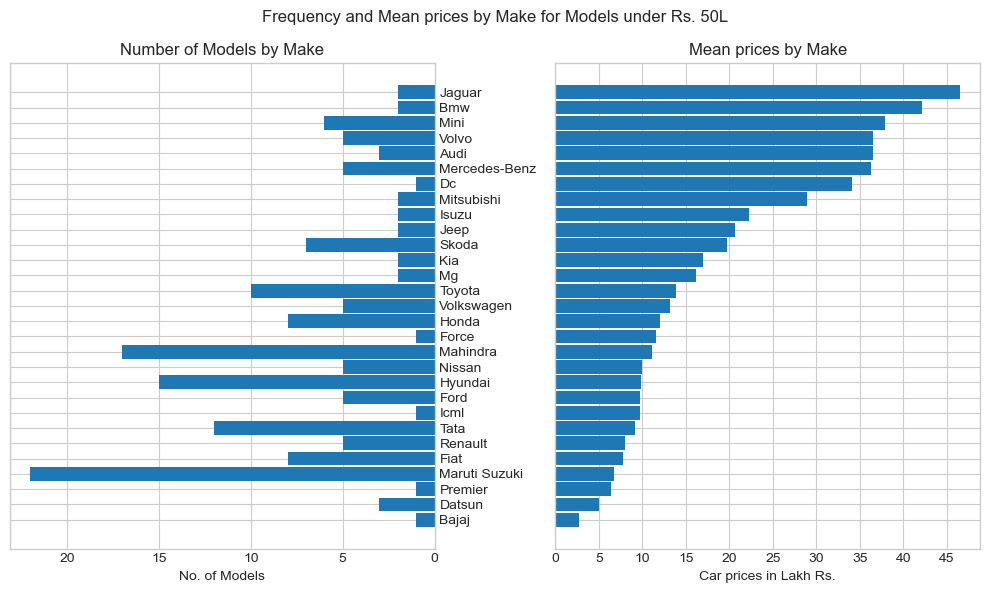

In [43]:
plt.style.use('seaborn-whitegrid')

make_price_50 = cars_df_50[['Price', 'Make']].groupby('Make').mean().sort_values(by='Price')
make_count_50 = cars_df_50[['Model', 'Make']].drop_duplicates().groupby('Make').count().reindex(make_price_50.index)

fig, ax = plt.subplots(1, 2, figsize=(10,6), sharey=True)

ax[1].barh(list(np.arange(len(make_price_50['Price']))), list(make_price_50['Price']), 
           height=0.9)
ax[0].barh(list(np.arange(len(make_count_50['Model']))), list(make_count_50['Model']), height=0.9)

ax[0].set_yticks(list(np.arange(len(make_price_50['Price']))))
ax[0].set_yticklabels(list(make_price_50.index))
ax[0].invert_xaxis()
ax[0].yaxis.tick_right()
ax[0].set(title='Number of Models by Make', xlabel='No. of Models')

ax[1].set(title='Mean prices by Make', xticks=np.arange(0,5.0E6, 5.0E5), xticklabels=np.arange(0,50,5),
         xlabel='Car prices in Lakh Rs.')
plt.suptitle('Frequency and Mean prices by Make for Models under Rs. 50L')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


#### A mix of pricing strategies active in the Indian Automobile Market
<b>Observations:</b><br>
We see a mix of product and pricing strategies in the Indian automobile market.<br>
 - Maruti Suzuki is the leader in low price segment (< Rs. 7 Lakhs) and offers the largest range of model choices.<br>
 - Companies like Tata, Hyundai, Mahindra compete in the mid-segment with the mean model price ranging from Rs. 7-9 Lakhs. They also offer a wide variety of models.<br>
 - As we move further up the mean pricing, we see the companies offering high end models (Rs. 25-45 Lakhs). Here the model variety is much lower than their mid segment counter parts.<br>
 
We also observe the difference between established players and unestablished/new players in the market by looking at the Number of models the manufacturer has to offer. Players like Bajaj, Premier, Kia, MG, Jeep can be seen as the new players in the market.

<b>Now let us look at some other categorical variables and how the Price varies with them :

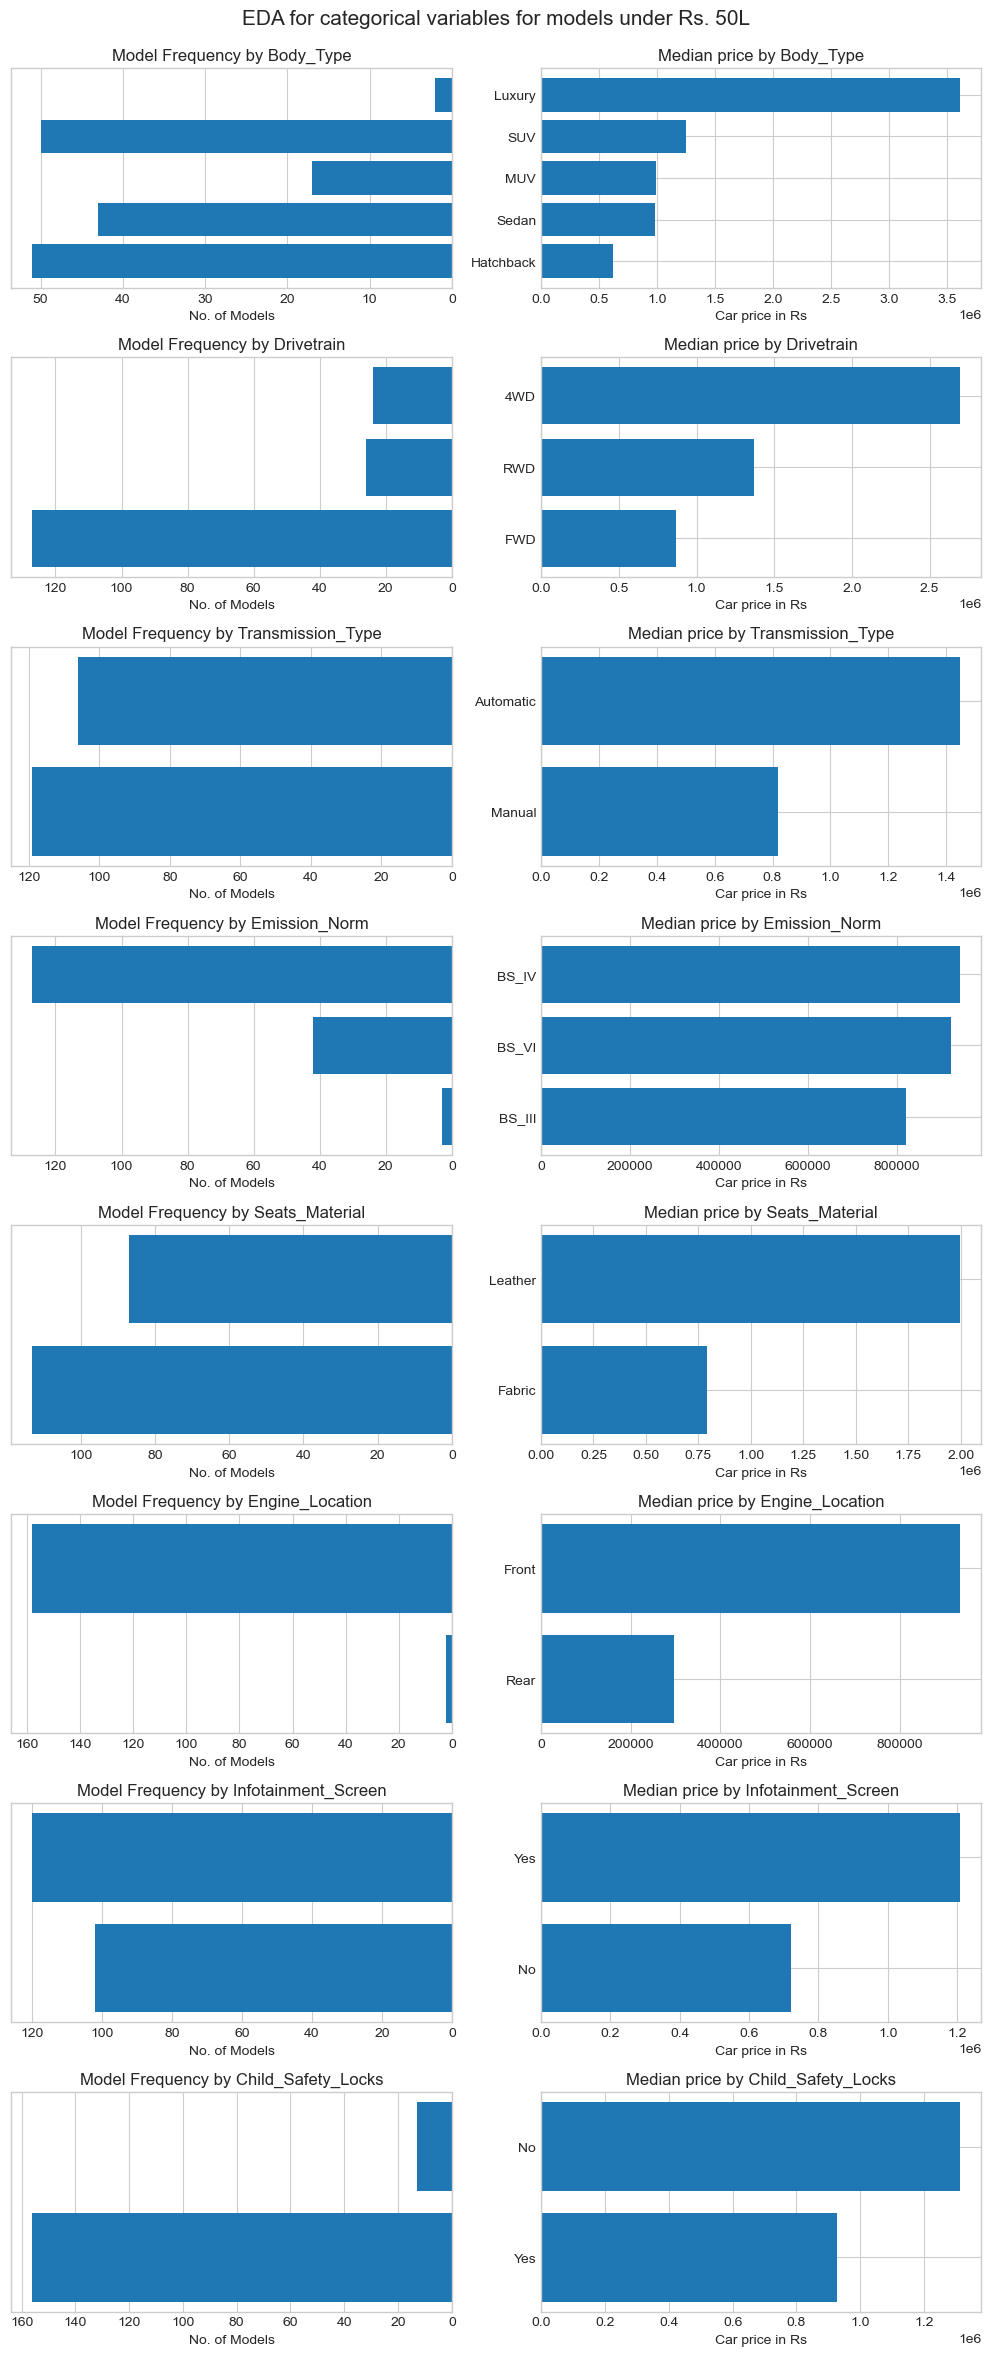

In [45]:
x = ['Body_Type', 'Drivetrain', 'Transmission_Type', 'Emission_Norm', 'Seats_Material', 'Engine_Location', 
     'Infotainment_Screen', 'Child_Safety_Locks']

fig = plt.figure(figsize=(10, 24))
for i, feat in enumerate(x):

    feat_price = cars_df_50[['Price', feat]].groupby(feat).median().sort_values(by='Price')
    feat_count = cars_df_50[['Model', feat]].drop_duplicates().groupby(feat).count().reindex(feat_price.index)
    
    sub1 = plt.subplot2grid(shape=(len(x),2), loc=(i,0))
    sub2 = plt.subplot2grid(shape=(len(x),2), loc=(i,1))
    
    sub1.barh(list(np.arange(len(feat_count))), list(feat_count['Model']))
    sub2.barh(list(np.arange(len(feat_price))), list(feat_price['Price']))
    
    sub1.set(title='Model Frequency by {}'.format(feat), xlabel='No. of Models',yticks=[], yticklabels=[])
    sub2.set(yticks=np.arange(len(feat_price)),  yticklabels=feat_price.index, 
              xlabel='Car price in Rs', title='Median price by {}'.format(feat))
    
    sub1.invert_xaxis()
    sub1.yaxis.tick_right()
    
plt.suptitle('EDA for categorical variables for models under Rs. 50L', fontsize=15)    
plt.tight_layout(rect=[0,0,1,0.97])

#### ! The SUV segment has the same depth of variety as the Hatchback segment !
 - The median price of the SUV segment is twice that of the hatchback segment.
 - Sedan is the next most competitive segment, followed by the MUV segment.

#### Models with Four wheel drive have a median price range almost double that Rear wheel drive models within the Rs. 50 Lakh range.
 - Front wheel drive is the most common drive train comprising of over 70% of the models in the Indian Market.

#### Automatic transmission models are on a rise in the Indian Market in the under Rs. 50L segment
 - The median price of car models automatic transmission is nearly 75% higher than median price of car models with manual transmission

#### Emission norm BS IV is the most popular with more that 70% of the car models adopting BS IV standards
 - Prices do not seem to be affected in any significant manner by the emission norm used.

#### Engine location doesn't have a significant impact
 - There aren't many car models with rear mounted engines but on a glance, models with engine location at the front seem to be less expensive.

#### We see that cars having infotainment screens are generally costlier than models without infotainment screens
 - Nearly twice as many models available that have screens than those which dont.

<b>Lastly we explore the Fuel Type predictor :

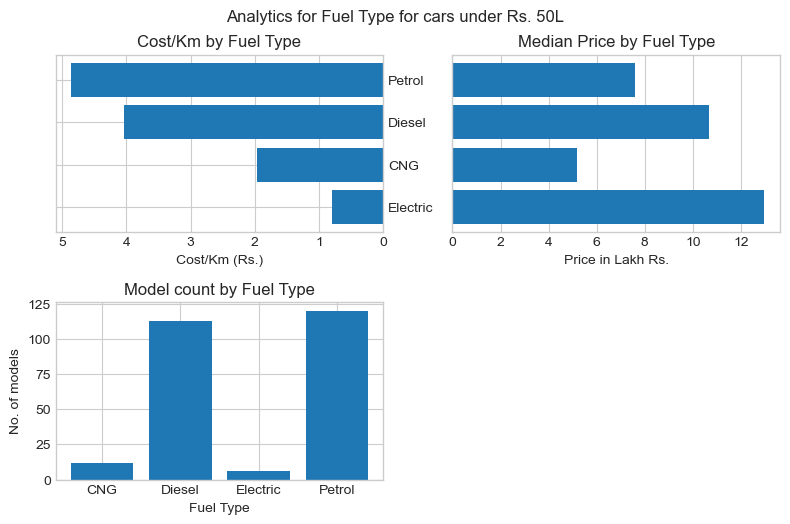

In [46]:
fig = plt.figure(figsize=(8,10))

sub1 = plt.subplot2grid(shape=(4,2), loc=(0,0), colspan=1)
sub2 = plt.subplot2grid(shape=(4,2), loc=(0,1))
sub3 = plt.subplot2grid(shape=(4,2), loc=(1,0))


Fuel_cost = cars_df_50[['Cost_per_Km', 'Fuel_Type']].groupby('Fuel_Type').median().sort_values(by='Cost_per_Km')
Fuel_price = cars_df_50[['Price', 'Fuel_Type']].groupby('Fuel_Type').median().reindex(Fuel_cost.index)
Fuel_model = cars_df_50[['Fuel_Type', 'Model']].drop_duplicates().groupby('Fuel_Type').count()                                                            

sub1.barh(np.arange(len(Fuel_cost)), Fuel_cost['Cost_per_Km'])
sub2.barh(np.arange(len(Fuel_price)), Fuel_price['Price'])
sub3.bar(np.arange(len(Fuel_model)), Fuel_model['Model'])


sub1.set(title='Cost/Km by Fuel Type', xlabel='Cost/Km (Rs.)', yticks=np.arange(len(Fuel_cost)),\
        yticklabels=Fuel_cost.index)
sub2.set(title='Median Price by Fuel Type', xlabel='Price in Lakh Rs.', xticks=np.arange(0, 14.0e5, 2e5),\
        xticklabels=np.arange(0, 14, 2), yticks=[], yticklabels=[])
sub3.set(title='Model count by Fuel Type', xticks=np.arange(len(Fuel_model)), xticklabels=Fuel_model.index,
        xlabel='Fuel Type', ylabel='No. of models')

sub1.invert_xaxis()
sub1.yaxis.tick_right()
plt.suptitle('Analytics for Fuel Type for cars under Rs. 50L')
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

#### The price of a car seems to vary with the Fuel type
 - Electric vehicles are the most economical to run while also being the costliest on average.
 - CNG also provides good running economy with the lowest median car price in the 50L range attributed to the lower segment cars on offer.
 - Maximum depth of models is found in petrol, followed by diesel (which was to be expected)

### 2.2. Exploration of Numerical Predictors

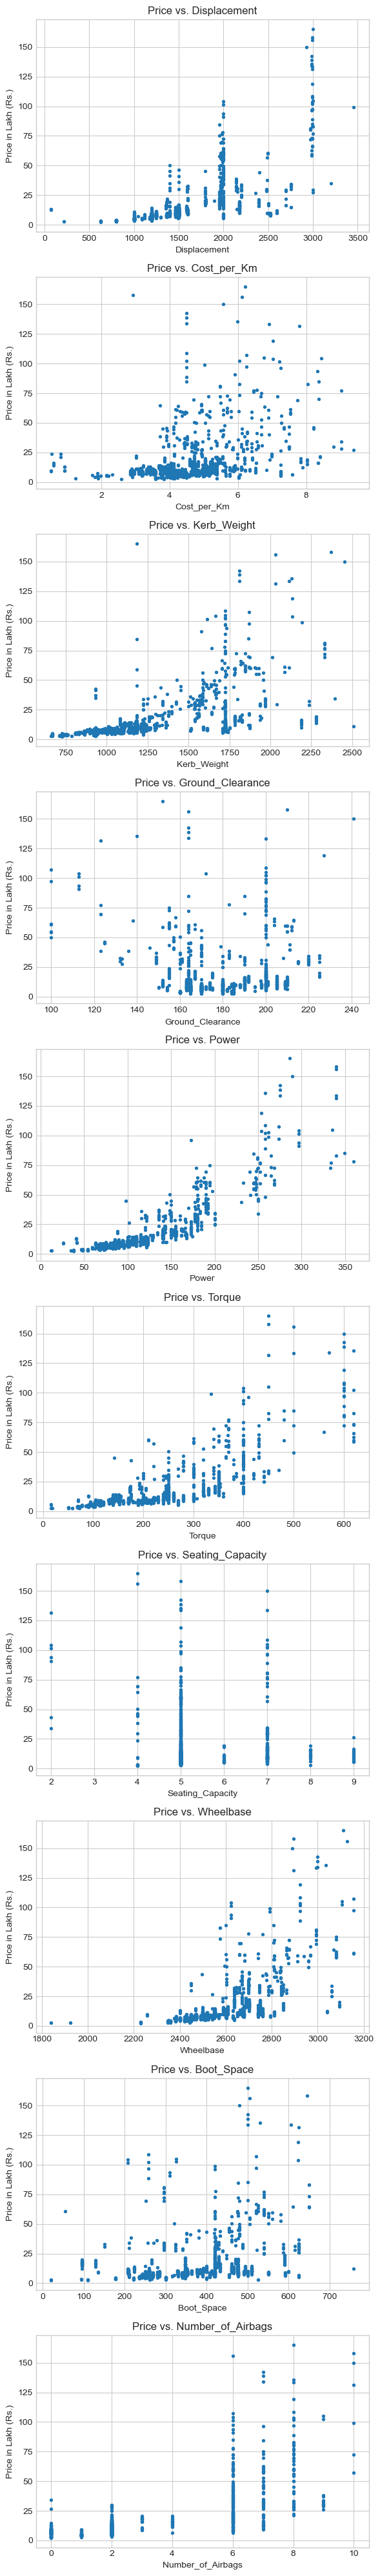

In [47]:
plot_nums = [feat for feat in num_vars if feat != 'Price']
fig, ax = plt.subplots(len(plot_nums), 1, figsize=(6, 40))

# We plot The target Price vs the rest of the numerical predictor variables

for i, feat in enumerate(plot_nums):

    ax[i].scatter(cars_df[feat], cars_df['Price'], s=8)
    ax[i].set(title='Price vs. {}'.format(feat), xlabel=feat, ylabel='Price in Lakh (Rs.)', 
              yticks=np.arange(0, 1.75E7, 0.25E7), yticklabels=np.arange(0, 175, 25))

plt.tight_layout()
plt.show()


#### The clearest trend wrt the target variable 'Price', amongst the numerical variables is seen with 'Power'.
 - Price seems to <u>non-linearly</u> vary with Power.
 - A similar trend can be observed with <b>Torque</b> and <b>Engine Displacement.</b>

Since we know that Engine displacement, Power and Torque are co-related, we will will be droping two of these three variables based on the pearson's correlation coeffiecients amongsts themselves and with the target variable 'Price'.<br>
We will also investigate these with scatter plots.

#### 'Kerb Weight' and 'Wheelbase' also show a positive trend with 'Price'.
 - This would mean that larger and heavier vehicles are generally costlier.<br>

This is to be expected to a certain degree since the more the material used in a car, the higher its price would be. Increased weight could also signal a higher 'Engine Displacement'. We will look into the relationship amongst these three variables as well.

#### 'Cost per Km' shows a slight positive correlation with 'Price'
 - This could be attributed to the affordability of the customers. 
 - Customer that buy costlier cars are not looking for high mileage but rather performance.

#### 'Number of Airbags' shows a clear positive trend with price.
 - Which is intuitive since costlier cars have greater emphasis on safety

#### 'Ground Clearance', 'Seating Capacity', 'Boot Space' show no clear trends in their scatter plots with 'Price'
 - The scatter plot is seemingly random

With this we finish the EDA section and move on to Statistical Feature selection & model assumptions validation.